In [1]:
#import necessary library
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

#drive's local file
sorbian_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.hsb'
german_path = '/content/drive/MyDrive/Colab Notebooks/train.hsb-de.de'

#read hsb sentences
with open(sorbian_path, 'r', encoding='utf-8') as f:
    sorbian_sentences = f.readlines()

#read german sentences
with open(german_path, 'r', encoding='utf-8') as f:
    german_sentences = f.readlines()



Mounted at /content/drive


In [ ]:
#dataset preprocess
def clean_and_align(sorbian_sentences, german_sentences, max_len=128):


    #清理空白和换行 remove empty sentences and /n
    sorbian_sentences = [s.strip() for s in sorbian_sentences if s.strip()]
    german_sentences = [s.strip() for s in german_sentences if s.strip()]

    #保持长度一致 keep align
    min_len = min(len(sorbian_sentences), len(german_sentences))
    sorbian_sentences = sorbian_sentences[:min_len]
    german_sentences = german_sentences[:min_len]

    #构建句对，过滤掉太长的句子 limitation of length of sentences
    filtered_pairs = []
    for s, g in zip(sorbian_sentences, german_sentences):
        if len(s.split()) < max_len and len(g.split()) < max_len:
            filtered_pairs.append((s, g))

    #去重（以句对为单位）remove duplicate sentences
    seen = set()
    unique_pairs = []
    for pair in filtered_pairs:
        if pair not in seen:
            seen.add(pair)
            unique_pairs.append(pair)

    #拆分成两个 list
    sorbian_clean, german_clean = zip(*unique_pairs) if unique_pairs else ([], [])

    return list(sorbian_clean), list(german_clean)

sorbian_sentences, german_sentences = clean_and_align(sorbian_sentences, german_sentences)


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from tqdm import tqdm

# 加载 Glot500 模型 load Glot model from hugging face
tokenizer = AutoTokenizer.from_pretrained("cis-lmu/glot500-base")
model = AutoModel.from_pretrained("cis-lmu/glot500-base")
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")


# 编码函数（mean pooling）
def embed_sentences(sentences):
    embeddings = []
    device = "cuda" if torch.cuda.is_available() else "cpu" #use gpu
    for sent in tqdm(sentences):
        inputs = tokenizer(sent, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        last_hidden = outputs.last_hidden_state.squeeze(0)  # shape: (seq_len, hidden_size)
        attention_mask = inputs['attention_mask'].squeeze(0)# mean pooling
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size())
        masked_hidden = last_hidden * mask_expanded
        sentence_embedding = masked_hidden.sum(0) / attention_mask.sum()
        embeddings.append(sentence_embedding.cpu().numpy())
    return np.array(embeddings)


# 分别生成两个语言的嵌入 generate embedding vectors
hsb_embeddings = embed_sentences(sorbian_sentences)
np.save("/content/drive/MyDrive/Colab Notebooks/glot500_hsb.npy", hsb_embeddings)
de_embeddings = embed_sentences(german_sentences)
np.save("/content/drive/MyDrive/Colab Notebooks/glot500_de.npy", de_embeddings)


KeyboardInterrupt: 

In [4]:
!pip install kneed
# 聚类 + 可视化 cluster + visualization
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from kneed import KneeLocator


drive.mount('/content/drive')

#使用 Elbow 方法选择最佳聚类数（K）
#Use Elbow and kneedle methods to select optimal number of clusters (K)
#silhouette score is not fitted cuz dataset too big-> running too long
def elbow_with_kneedle(embeddings: np.ndarray, k_range=range(2, 21), title="Elbow Curve with Auto K Detection") -> int:
    """
    使用 inertia 曲线 + Kneedle 方法自动检测最佳聚类数 K。
    Elbow method + KneeLocator to auto-detect best K.
    """
    inertias = []
    print("start calculating KMeans different K value under inertia...")
    for k in k_range:
        print(f"Fitting KMeans for k={k}")
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        inertias.append(kmeans.inertia_)

    # 自动检测“肘部”点  detect elbow point
    kneedle = KneeLocator(k_range, inertias, curve="convex", direction="decreasing")
    best_k = kneedle.elbow

    # 可视化 Elbow 曲线 plot elbow curve
    plt.figure(figsize=(8, 5))
    plt.plot(k_range, inertias, 'bo-', label="Inertia")
    if best_k:
        plt.axvline(x=best_k, color='red', linestyle='--', label=f"Best K = {best_k}")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Inertia")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.xticks(list(k_range))
    plt.show()

    if best_k:
        print(f"best K: {best_k}")
    else:
        print("no clear elbow found")

    return best_k


#用pca降维画图 reduce high dimensions to low using PCA
def plot_clusters_pca(embeddings, labels, title):
    print("Running PCA dimensionality reduction...")
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    reduced = pca.fit_transform(embeddings)
    print("PCA completed. Generating plot...")

    # 可视化 visualization
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', alpha=0.7)
    plt.title(title)
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.colorbar(scatter)
    plt.show()



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#calculate hsb-label

import numpy as np
from sklearn.cluster import KMeans
from google.colab import drive

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_hsb.npy")  # Upper Sorbian
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_de.npy")    # German

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels
# 聚类 cluster 每个句子和对应的cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=5)#手动写5 de的最佳
de_labels = perform_kmeans(de_embeddings, n_clusters=5)


Clustering in progress...
Clustering completed.
Clustering in progress...
Clustering completed.


start calculating KMeans different K value under inertia...
Fitting KMeans for k=1
Fitting KMeans for k=2
Fitting KMeans for k=3
Fitting KMeans for k=4
Fitting KMeans for k=5
Fitting KMeans for k=6
Fitting KMeans for k=7
Fitting KMeans for k=8
Fitting KMeans for k=9
Fitting KMeans for k=10
Fitting KMeans for k=11
Fitting KMeans for k=12
Fitting KMeans for k=13
Fitting KMeans for k=14
Fitting KMeans for k=15
Fitting KMeans for k=16
Fitting KMeans for k=17
Fitting KMeans for k=18
Fitting KMeans for k=19
Fitting KMeans for k=20
Fitting KMeans for k=21
Fitting KMeans for k=22
Fitting KMeans for k=23
Fitting KMeans for k=24


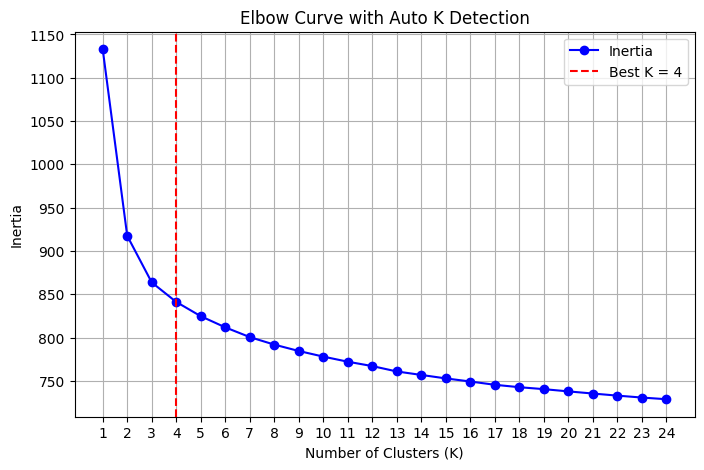

best K: 4
4
Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


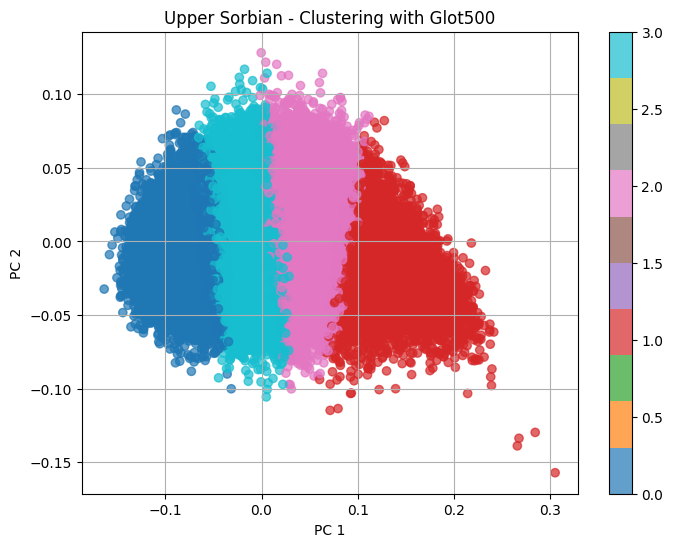

In [23]:

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_hsb.npy")  # Upper Sorbian


# 判断最佳K determine optimal k--uppersobian
#The best k is 4
best_k_hsb = elbow_with_kneedle(hsb_embeddings, k_range=range(1, 25))
print(best_k_hsb)
# 聚类 cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=best_k_hsb)

# 可视化 visualization
plot_clusters_pca(hsb_embeddings, hsb_labels, "Upper Sorbian - Clustering with Glot500")


start calculating KMeans different K value under inertia...
Fitting KMeans for k=1
Fitting KMeans for k=2
Fitting KMeans for k=3
Fitting KMeans for k=4
Fitting KMeans for k=5
Fitting KMeans for k=6
Fitting KMeans for k=7
Fitting KMeans for k=8
Fitting KMeans for k=9
Fitting KMeans for k=10
Fitting KMeans for k=11
Fitting KMeans for k=12
Fitting KMeans for k=13
Fitting KMeans for k=14
Fitting KMeans for k=15
Fitting KMeans for k=16
Fitting KMeans for k=17
Fitting KMeans for k=18
Fitting KMeans for k=19
Fitting KMeans for k=20
Fitting KMeans for k=21
Fitting KMeans for k=22
Fitting KMeans for k=23
Fitting KMeans for k=24


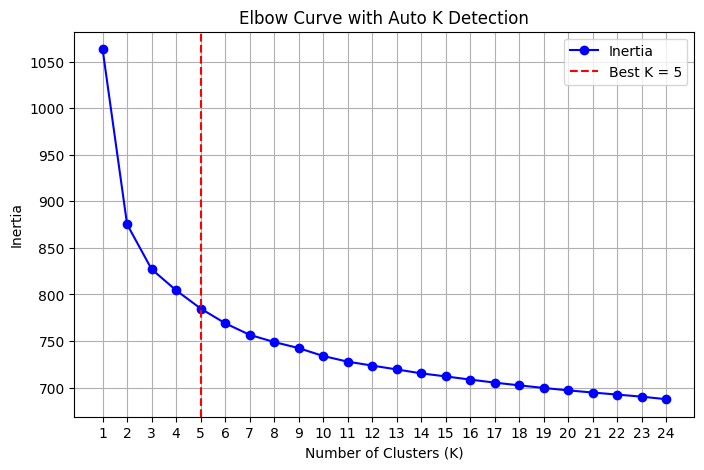

best K: 5
Clustering in progress...
Clustering completed.
Running PCA dimensionality reduction...
PCA completed. Generating plot...


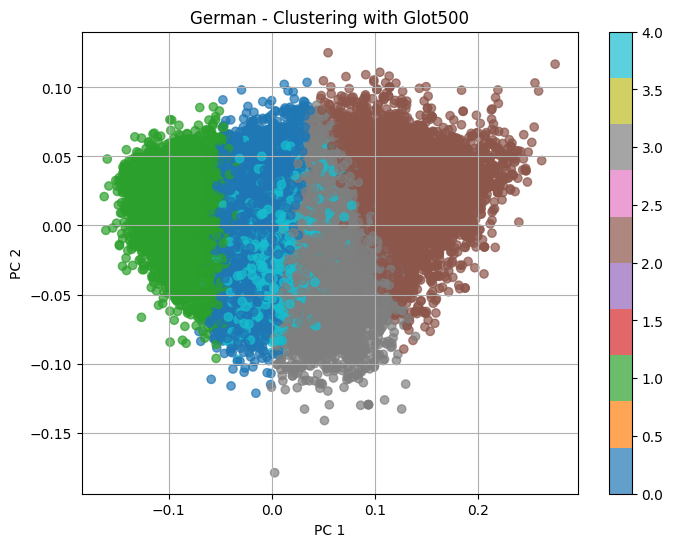

In [7]:
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_de.npy")    # German

# de
#The best k is 5
best_k_de = elbow_with_kneedle(de_embeddings, k_range=range(1, 25))

de_labels = perform_kmeans(de_embeddings, n_clusters=best_k_de)

plot_clusters_pca(de_embeddings, de_labels, "German - Clustering with Glot500")

In [8]:
#用tfidf分来找出每个cluster中重要的关键词 use TF-IDF score to find the most important word of each cluster
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
german_stopwords = stopwords.words('german')# specific stopword group is neccessary
def extract_cluster_keywords(df, text_col="sentence", cluster_col="cluster_label", top_n=3):
    """
    对每个 cluster 提取 TF-IDF 得分最高的关键词
    参数:
        df: 包含句子和聚类标签的 pandas DataFrame
        text_col: 文本列名称（默认 'sentence'）
        cluster_col: 聚类标签列名称（默认 'cluster_label'）
        top_n: 每个聚类提取的关键词数量
    返回:
        一个字典，key 是 cluster id，value 是关键词列表
    """
    """
    对每个 cluster 提取 TF-IDF 得分最高的关键词
    parameter:
        df: DataFrame include cluster and sentence
        text_col: name of text column (default 'sentence')
        cluster_col: name of cluster label column (default 'cluster_label')
        top_n: number of keywords to extract from each cluster
        a dict, key is cluster id, value is a list of keywords
    """
    cluster_groups = defaultdict(list)

    # Group sentences by cluster
    for _, row in df.iterrows():
        cluster_groups[row[cluster_col]].append(row[text_col])

    # Extract top keywords for each cluster
    cluster_keywords = {}
    for cluster_id, sentences in cluster_groups.items():
        vectorizer = TfidfVectorizer(
            max_df=0.8,
            stop_words=german_stopwords,#we use specific stopwords group
            lowercase=True)
        tfidf_matrix = vectorizer.fit_transform(sentences)
        tfidf_scores = tfidf_matrix.sum(axis=0).A1
        words = vectorizer.get_feature_names_out()
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_words = [words[i] for i in top_indices]
        cluster_keywords[cluster_id] = top_words

    return cluster_keywords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# 创建 DataFrame create df
df_sorbian = pd.DataFrame({
    "sentence": sorbian_sentences,
    "cluster_label": hsb_labels
})
cluster_keywords = extract_cluster_keywords(df_sorbian)#no public stopword group for hsb
for cid, keywords in cluster_keywords.items():
    print(f"Cluster {cid}: {keywords}")

Cluster 1: ['to', 'je', 'ja']
Cluster 2: ['je', 'na', 'za']
Cluster 0: ['za', 'na', 'je']
Cluster 4: ['je', 'to', 'na']
Cluster 3: ['je', 'na', 'zo']


In [9]:
df_de = pd.DataFrame({
    "sentence": german_sentences,
    "cluster_label": de_labels
})
cluster_keywords = extract_cluster_keywords(df_de)
for cid, keywords in cluster_keywords.items():
    print(f"Cluster {cid}: {keywords}")

Cluster 3: ['beide', 'heute', 'kommt']
Cluster 0: ['sorbische', 'sorbischen', 'wurde']
Cluster 1: ['sorbischen', 'sorbische', 'sprache']
Cluster 2: ['hast', 'ja', 'schon']
Cluster 4: ['herr', 'gott', 'herrn']


In [3]:
!pip install -q spacy scikit-learn nltk
!python -m spacy download de_core_news_sm

import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
# 加载 spaCy 和 NLTK 的德语 stopwords stopwords load stopword of spaCy and NLTK
nlp = spacy.load("de_core_news_sm")
spacy_stopwords = nlp.Defaults.stop_words
nltk_stopwords = set(stopwords.words("german"))
combined_stopwords = spacy_stopwords.union(nltk_stopwords)

# 文本清洗函数：只保留有意义词（长度 > 2、非标点、非数字、非停用词） keep meaningful words
def clean_sentences_combined(sentences):
    cleaned = []
    for doc in nlp.pipe(sentences, batch_size=32):
        tokens = [
            token.lemma_.lower() for token in doc
            if token.is_alpha and not token.is_punct and len(token.text) > 2
            and token.lemma_.lower() not in combined_stopwords
        ]
        cleaned.append(" ".join(tokens))
    return cleaned
def extract_keywords_by_cluster(df, text_col="sentence", cluster_col="cluster_label", top_n=10):
    cluster_keywords = {}
    grouped = df.groupby(cluster_col)[text_col].apply(list)

    for cluster_id, sentences in grouped.items():
        cleaned = clean_sentences_combined(sentences)
        vectorizer = TfidfVectorizer()
        X = vectorizer.fit_transform(cleaned)
        tfidf_scores = X.sum(axis=0).A1
        words = vectorizer.get_feature_names_out()
        top_indices = tfidf_scores.argsort()[::-1][:top_n]
        top_words = [(words[i], round(tfidf_scores[i], 3)) for i in top_indices]
        cluster_keywords[cluster_id] = top_words

    return cluster_keywords


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 76.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df_de = pd.DataFrame({
    "sentence": german_sentences,
    "cluster_label": de_labels
})
# 假设你已有 German 聚类结果 df，其中有 'sentence' 和 'cluster_label'
cluster_keywords = extract_keywords_by_cluster(df_de)

# 打印前几个聚类的关键词
for cid, words in cluster_keywords.items():
    print(f"\nCluster {cid}:")
    for word , score in words:
        print(f"  {word}: {score}")



Cluster 0:
  sorbisch: 319.212
  neu: 154.697
  kind: 130.342
  sprache: 106.195
  finden: 100.99
  geben: 97.671
  bautzen: 93.662
  wichtig: 91.033
  vieler: 85.283
  mensch: 84.504

Cluster 1:
  sorbisch: 521.031
  sprache: 202.35
  kind: 180.365
  domowina: 156.729
  neu: 148.051
  bautzen: 133.007
  sächsisch: 129.648
  sachsen: 122.181
  volk: 109.64
  sorben: 107.184

Cluster 2:
  sehen: 69.809
  helfen: 67.679
  sagen: 62.394
  brauchen: 56.856
  wissen: 44.334
  bitte: 43.241
  spielen: 40.761
  herr: 40.123
  kind: 36.218
  möchten: 33.639

Cluster 3:
  stammen: 90.927
  schön: 89.478
  kind: 87.092
  brauchen: 81.868
  sehen: 80.495
  alt: 76.228
  haus: 75.154
  bleiben: 70.928
  stehen: 70.515
  freund: 66.935

Cluster 4:
  herr: 194.94
  gott: 167.103
  sprechen: 103.464
  sehen: 86.909
  jesus: 79.518
  sagen: 76.911
  mensch: 73.943
  geben: 64.412
  kind: 61.677
  leben: 60.138


In [15]:
!pip install -q transformers

from transformers import pipeline

# 加载多语言主题分类模型 load model
classifier = pipeline(
    "text-classification",
    model="cardiffnlp/tweet-topic-base-multilingual",
    top_k=1
)
def classify_cluster_topics(df, text_col="sentence", cluster_col="cluster_label", num_sentences=5):
    """
    使用预训练主题模型，为每个 cluster 自动打标签。
    参数:
        df: 包含句子和聚类编号的 DataFrame
        text_col: 句子列名
        cluster_col: 聚类标签列名
        num_sentences: 每个 cluster 用多少句拼接作为主题输入
    返回:
        一个 dict，key 是 cluster ID，value 是主题标签
    """
    from collections import defaultdict

    cluster_sentences = defaultdict(list)
    for _, row in df.iterrows():
        cluster_sentences[row[cluster_col]].append(row[text_col])

    cluster_topics = {}
    for cluster_id, sentences in cluster_sentences.items():
        text_input = " ".join(sentences[:num_sentences])  # 拼接部分句子
        prediction = classifier(text_input)[0][0]  # 取第一条预测结果
        cluster_topics[cluster_id] = prediction['label']


    return cluster_topics


cluster_topic_labels_hsb = classify_cluster_topics(df_de)
# 打印结果 print result
print(f"glot500_hsb_topics")
for cluster_id, topic in cluster_topic_labels_hsb.items():
    print(f"Cluster {cluster_id}: {topic}")

cluster_topic_labels_de = classify_cluster_topics(df_sorbian)
# 打印结果
print(f"glot500_de_topics")
for cluster_id, topic in cluster_topic_labels_de.items():
    print(f"Cluster {cluster_id}: {topic}")

Device set to use cpu


glot500_hsb_topics
Cluster 3: diaries_&_daily_life
Cluster 0: learning_&_educational
Cluster 1: news_&_social_concern
Cluster 2: diaries_&_daily_life
Cluster 4: other_hobbies
glot500_de_topics
Cluster 1: diaries_&_daily_life
Cluster 2: arts_&_culture
Cluster 0: news_&_social_concern
Cluster 4: news_&_social_concern
Cluster 3: news_&_social_concern


In [4]:
from collections import defaultdict, Counter

def compare_cross_lingual_cluster_consistency(hsb_labels, de_labels, hsb_sentences, de_sentences):
    """
    比较 Upper Sorbian 的每个聚类中句子在 German 中的聚类分布。
    Compare how consistently each Upper Sorbian cluster maps into German clusters.
    返回：
    - report: dict — 每个 Upper Sorbian cluster 的映射分析，包括：
        - 映射最多的 German cluster ID
        - 一致性占比（百分比形式）
        - 各个 German cluster 的分布统计
     Returns:
    - report: dict — mapping statistics per Upper Sorbian cluster:
        - 'top_german_cluster': the German cluster with the most aligned sentences
        - 'consistency_ratio': proportion of sentences in that dominant cluster
        - 'distribution': full count of how aligned sentences are distributed across German clusters
    """
    cluster_map = defaultdict(list)  # 存储：Upper Sorbian cluster_id -> index列表
                                     # save：Upper Sorbian cluster_id -> index list
    for idx, label in enumerate(hsb_labels):
        cluster_map[label].append(idx)

    report = {}

    for cluster_id, indices in cluster_map.items():
        # 找出对应德语句子的聚类标签 find cluster of corresponding german sentences
        german_cluster_ids = [de_labels[i] for i in indices]
        german_counts = Counter(german_cluster_ids)
        total = len(german_cluster_ids)

        # 找到最常出现的 German cluster（占比最高）find most common cluster
        top_cluster, top_count = german_counts.most_common(1)[0]
        ratio = top_count / total
        # 保留top3
        top3_distribution = dict(german_counts.most_common(3))
        # 构建报告
        report[cluster_id] = {
            "top_german_cluster": top_cluster,
            "consistency_ratio": round(ratio, 2),
            "distribution_top3": top3_distribution,

        }

    return report
def describe_crosslingual_cluster_mapping(report: dict):
    """
    输出 Upper Sorbian 每个聚类在 German 中的聚类分布描述（用于人类阅读）
    Print human-readable description of how each Upper Sorbian cluster maps to German clusters

    参数：
    - report: dict，来自 compare_cross_lingual_cluster_consistency() 的输出

    功能：
    - 不强调 cluster ID 的语义一致性
    - 更清楚地表述“映射到了哪个 German cluster（占比多少）”
    - 显示每个分布（distribution）、Upper Sorbian 示例句、德语翻译对照句
    """
    for cid, info in sorted(report.items()):
        print(f"\nUpper Sorbian Cluster {cid}:")
        print(f"  → Most mapped to German Cluster {info['top_german_cluster']} "
              f"({info['consistency_ratio']*100:.1f}% of sentences)")

        top3_dist = info["distribution_top3"]
        total = sum(top3_dist.values())
        formatted_dist = {
            f"Cluster {k}": f"{(v / total) * 100:.1f}%" for k, v in top3_dist.items()
        }

        print(f"  → Top-3 German cluster distribution (percentage): {formatted_dist}")


In [7]:
report = compare_cross_lingual_cluster_consistency(hsb_labels, de_labels, sorbian_sentences, german_sentences)
describe_crosslingual_cluster_mapping(report)  # 用更合理语言描述映射结果



Upper Sorbian Cluster 0:
  → Most mapped to German Cluster 1 (72.0% of sentences)
  → Top-3 German cluster distribution (percentage): {'Cluster 1': '74.3%', 'Cluster 5': '20.3%', 'Cluster 0': '5.4%'}

Upper Sorbian Cluster 1:
  → Most mapped to German Cluster 6 (46.0% of sentences)
  → Top-3 German cluster distribution (percentage): {'Cluster 6': '47.6%', 'Cluster 4': '28.4%', 'Cluster 2': '24.0%'}

Upper Sorbian Cluster 2:
  → Most mapped to German Cluster 2 (31.0% of sentences)
  → Top-3 German cluster distribution (percentage): {'Cluster 2': '38.8%', 'Cluster 0': '32.6%', 'Cluster 4': '28.7%'}

Upper Sorbian Cluster 3:
  → Most mapped to German Cluster 5 (43.0% of sentences)
  → Top-3 German cluster distribution (percentage): {'Cluster 5': '46.5%', 'Cluster 0': '32.8%', 'Cluster 1': '20.7%'}

Upper Sorbian Cluster 4:
  → Most mapped to German Cluster 0 (40.0% of sentences)
  → Top-3 German cluster distribution (percentage): {'Cluster 0': '51.4%', 'Cluster 5': '27.0%', 'Cluster 2': 

In [19]:
#detailed edition
from collections import defaultdict, Counter

def compare_cross_lingual_cluster_consistency_full(hsb_labels, de_labels, hsb_sentences, de_sentences):
    """
    比较 Upper Sorbian 的每个聚类中句子在 German 中的聚类分布（完整分布 + 百分比）。
    Returns:
    - report: dict — 每个 Upper Sorbian cluster 的映射分析，包括：
        - top_german_cluster: 最多映射的 German cluster ID
        - consistency_ratio: 该 German cluster 所占比例
        - distribution_full: 所有 German cluster 的原始数量分布
        - distribution_percent: 所有 German cluster 的百分比分布（字符串形式，百分数）
    """
    cluster_map = defaultdict(list)
    for idx, label in enumerate(hsb_labels):
        cluster_map[label].append(idx)

    report = {}

    for cluster_id, indices in cluster_map.items():
        german_cluster_ids = [de_labels[i] for i in indices]
        german_counts = Counter(german_cluster_ids)
        total = len(german_cluster_ids)

        top_cluster, top_count = german_counts.most_common(1)[0]
        ratio = top_count / total

        percent_dist = {k: f"{(v / total) * 100:.1f}%" for k, v in german_counts.items()}

        report[cluster_id] = {
            "top_german_cluster": top_cluster,
            "consistency_ratio": round(ratio, 2),
            "distribution_full": dict(german_counts),
            "distribution_percent": percent_dist
        }

    return report
def describe_crosslingual_cluster_mapping_full(report: dict):
    """
    输出包含完整百分比分布的跨语言聚类映射分析。
    """
    for cid, info in sorted(report.items()):
        print(f"\nUpper Sorbian Cluster {cid}:")
        print(f"  → Most mapped to German Cluster {info['top_german_cluster']} "
              f"({info['consistency_ratio']*100:.1f}% of sentences)")
        print(f"  → Full German cluster distribution (percentage): {info['distribution_percent']}")
        print(f"  → Raw distribution: {info['distribution_full']}")

import pandas as pd

def convert_cluster_report_to_dataframe_full(report: dict) -> pd.DataFrame:
    rows = []
    for cid, info in sorted(report.items()):
        row = {
            "Upper_Sorbian_Cluster": cid,
            "Top_German_Cluster": info["top_german_cluster"],
            "Top_Cluster_Ratio": info["consistency_ratio"]
        }

        # 加入百分比分布
        for gcid, percent in info["distribution_percent"].items():
            row[f"German_Cluster_{gcid}_%"] = percent

        # 加入原始数量分布
        for gcid, count in info["distribution_full"].items():
            row[f"German_Cluster_{gcid}_count"] = count

        rows.append(row)
    return pd.DataFrame(rows)


# 生成报告
report = compare_cross_lingual_cluster_consistency_full(hsb_labels, de_labels, sorbian_sentences, german_sentences)

# 打印可读版本
describe_crosslingual_cluster_mapping_full(report)

# 转 DataFrame（可选）
df = convert_cluster_report_to_dataframe_full(report)
df.to_csv("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_k_12.csv", index=False)  # 保存为CSV（可选）




Upper Sorbian Cluster 0:
  → Most mapped to German Cluster 1 (36.0% of sentences)
  → Full German cluster distribution (percentage): {np.int32(1): '36.0%', np.int32(8): '16.9%', np.int32(0): '24.0%', np.int32(4): '4.0%', np.int32(3): '3.2%', np.int32(9): '10.2%', np.int32(5): '3.2%', np.int32(6): '2.2%', np.int32(10): '0.4%', np.int32(11): '0.0%', np.int32(7): '0.0%'}
  → Raw distribution: {np.int32(1): 2242, np.int32(8): 1053, np.int32(0): 1494, np.int32(4): 247, np.int32(3): 197, np.int32(9): 638, np.int32(5): 200, np.int32(6): 134, np.int32(10): 22, np.int32(11): 2, np.int32(7): 1}

Upper Sorbian Cluster 1:
  → Most mapped to German Cluster 2 (35.0% of sentences)
  → Full German cluster distribution (percentage): {np.int32(6): '3.5%', np.int32(7): '20.5%', np.int32(2): '34.7%', np.int32(10): '25.7%', np.int32(11): '10.2%', np.int32(4): '0.5%', np.int32(3): '4.5%', np.int32(1): '0.1%', np.int32(5): '0.1%', np.int32(0): '0.1%'}
  → Raw distribution: {np.int32(6): 127, np.int32(7): 74

In [18]:
#calculate hsb-label

import numpy as np
from sklearn.cluster import KMeans
from google.colab import drive

# 加载保存好的嵌入向量 Load pre-saved sentence embeddings
hsb_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_hsb.npy")  # Upper Sorbian
de_embeddings = np.load("/content/drive/MyDrive/Colab Notebooks/glot500/glot500_de.npy")    # German

#kmeans方法用最佳的k值 kmeans using opimal k
def perform_kmeans(embeddings, n_clusters):
    print("Clustering in progress...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(embeddings)
    print("Clustering completed.")
    return labels
# 聚类 cluster 每个句子和对应的cluster
hsb_labels = perform_kmeans(hsb_embeddings, n_clusters=12)
de_labels = perform_kmeans(de_embeddings, n_clusters=12)


Clustering in progress...
Clustering completed.
Clustering in progress...
Clustering completed.


In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import Counter
from google.colab import drive

# 挂载 Google Drive
drive.mount('/content/drive')

# 设置路径前缀
base_path = "/content/drive/MyDrive/Colab Notebooks/glot500"

# 分布熵计算函数
def compute_entropy(distribution: dict) -> float:
    counts = np.array(list(distribution.values()))
    probs = counts / counts.sum()
    return round(float(-np.sum(probs * np.log2(probs + 1e-12))), 4)

# 从CSV中计算平均主映射比例 + 平均分布熵
def summarize_from_csv(file_path: str) -> dict:
    df = pd.read_csv(file_path)
    cluster_cols = [col for col in df.columns if col.endswith("_count")]

    top_ratios = []
    entropies = []

    for _, row in df.iterrows():
        distribution = {
            int(col.split("_")[2]): int(row[col])
            for col in cluster_cols if not pd.isna(row[col])
        }
        if not distribution:
            continue
        top_ratio = max(distribution.values()) / sum(distribution.values())
        entropy = compute_entropy(distribution)
        top_ratios.append(top_ratio)
        entropies.append(entropy)

    return {
        "file": os.path.basename(file_path),
        "avg_top_mapping_ratio": round(np.mean(top_ratios), 4),
        "avg_entropy": round(np.mean(entropies), 4)
    }

# 遍历 labse_k_7.csv 至 labse_k_12.csv
results = []
for k in range(7, 13):
    file_path = os.path.join(base_path, f"glot500_k_{k}.csv")
    if os.path.exists(file_path):
        summary = summarize_from_csv(file_path)
        summary["k"] = k
        results.append(summary)

# 保存并输出汇总
df_summary = pd.DataFrame(results)
print(df_summary)
summary_csv_path = os.path.join(base_path, "glot500_k_summary.csv")
df_summary.to_csv(summary_csv_path, index=False)
print(f"Saved summary to: {summary_csv_path}")




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
               file  avg_top_mapping_ratio  avg_entropy   k
0   glot500_k_7.csv                 0.4453       1.9601   7
1   glot500_k_8.csv                 0.3860       2.1081   8
2   glot500_k_9.csv                 0.3707       2.2283   9
3  glot500_k_10.csv                 0.3407       2.3450  10
4  glot500_k_11.csv                 0.3338       2.4373  11
5  glot500_k_12.csv                 0.3335       2.4883  12
Saved summary to: /content/drive/MyDrive/Colab Notebooks/glot500/glot500_k_summary.csv
